<a href="https://colab.research.google.com/github/MuradovMaks/EfficientNetV2S_Stanford_dogs/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F%20%D0%BF%D0%BE%D1%80%D0%BE%D0%B4%20%D1%81%D0%BE%D0%B1%D0%B0%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка датасета и первичная обработка

In [ ]:
import keras
print(keras.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2S

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

3.5.0


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-11-23 13:02:18--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  9.43MB/s    in 82s     

2024-11-23 13:03:42 (9.01 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
!unzip -qo 'stanford_dogs' -d ./dataset
IMAGE_PATH = './dataset/'

In [ ]:
#Отфильтруем поврежденные изображения

num_skipped = 0

for folder_name in os.listdir(IMAGE_PATH):
  folder_path = os.path.join(IMAGE_PATH,folder_name)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path,img)
    try:
      fimg = open(img_path,'rb')
      is_jfif = b'JFIF' in fimg.peek(10)
    finally:
      fimg.close()
    if not is_jfif:
      num_skipped+=1
      os.remove(img_path)


print(num_skipped)

10


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
#Генерация датасета
train_ds,val_ds = keras.utils.image_dataset_from_directory(IMAGE_PATH,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE,validation_split=0.2,subset='both',shuffle=True,seed=42)
print(type(train_ds))
total_size = len(train_ds)
test_size = int(0.1 * total_size)  # 10% для теста
train_size = total_size - test_size

# Создаем test_ds из оригинального train_ds
test_ds = train_ds.skip(train_size)

# Обновляем train_ds, чтобы он содержал только обучающие данные
train_ds = train_ds.take(train_size)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
print(type(train_ds))
print(type(val_ds))
print(type(test_ds))

<class 'tensorflow.python.data.ops.take_op._TakeDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.skip_op._SkipDataset'>


In [ ]:
#Метки датасета

CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
CLASS_COUNT = len(CLASS_LIST)
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

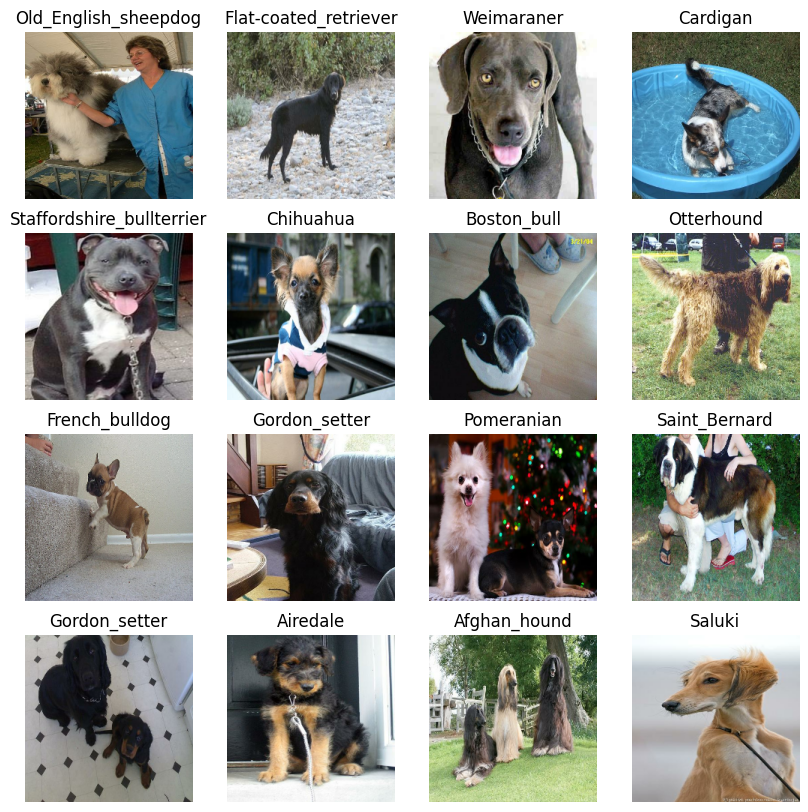

In [ ]:
plt.figure(figsize=(10,10))
for image,labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i + 1)
    plt.imshow(keras.utils.img_to_array(image[i]).astype('uint8'))
    plt.title(CLASS_LIST[labels[i]])
    plt.axis('off')


In [ ]:
#Аугментируем данные
augmentation_data_layers = [
    layers.RandomRotation(0.15),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomFlip(),
    layers.RandomTranslation(height_factor=0.1,width_factor=0.1,fill_mode='nearest')

]
# Применяем аугментацию к данным

def aug_data(images):
  for layer in augmentation_data_layers:
    images = layer(images)
  return images

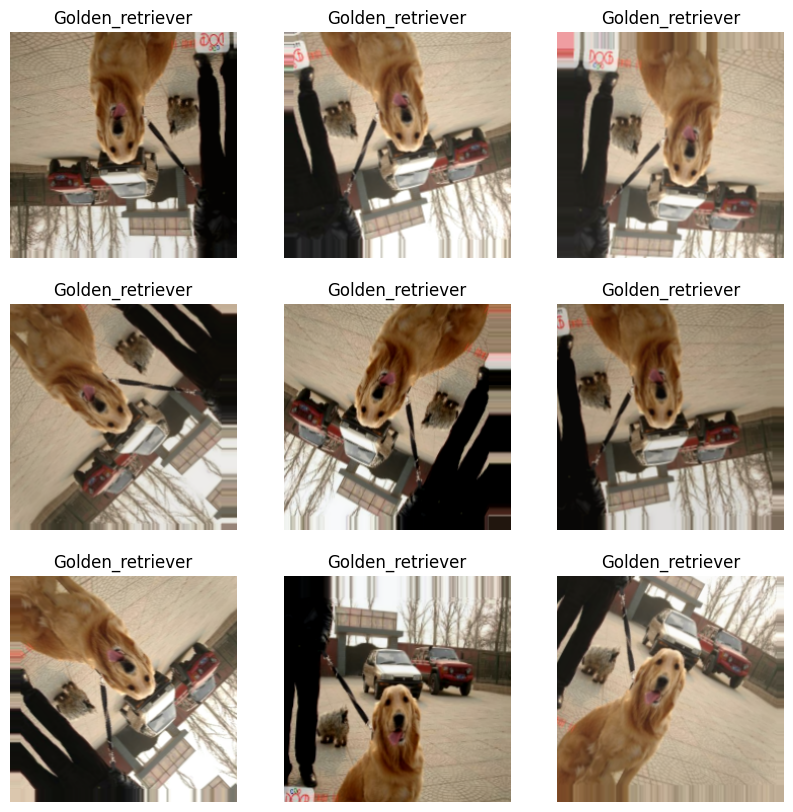

In [ ]:
#Покажем аугментированные данные
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
  for i in range(9):
    augment_img = aug_data(images[0])
    plt.subplot(3,3,i + 1)
    plt.imshow(keras.utils.img_to_array(augment_img).astype('uint8'))
    plt.title(CLASS_LIST[labels[0]])
    plt.axis('off')


In [ ]:
#Предобработаем данные применим аугментацию и one hot coding для мультклассовой классификации по типу Кошка Собака Попугай будет таблица 0 1 0. Где 1 соответсвует верному классу
train_ds = train_ds.map(lambda x,y: (aug_data(x),keras.ops.one_hot(y,CLASS_COUNT)),num_parallel_calls=tf_data.AUTOTUNE)
val_ds = val_ds.map(lambda x,y: (x,keras.ops.one_hot(y,CLASS_COUNT)),num_parallel_calls=tf_data.AUTOTUNE)
test_ds = test_ds.map(lambda x,y: (x,keras.ops.one_hot(y,CLASS_COUNT)),num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)



# Вспомогательные функции

In [ ]:
def show_plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1,len(acc) +1)
  plt.figure()
  plt.plot(epochs,acc,'r',label='Точность на обучающей выборке')
  plt.plot(epochs,val_acc,'b',label='Точность на валидационной выборке')
  plt.legend()
  plt.figure()
  plt.plot(epochs,loss,'r',label='Потери на обучающей выборке')
  plt.plot(epochs,val_loss,'b',label='Потери на валидационной выборке')
  plt.legend()
  plt.show()


In [ ]:
#Перенос обучения с предварительно обученными весами в ImageNet

def build_model(num_classes):
  inputs = layers.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
  model = EfficientNetV2S(include_top=False,weights='imagenet',input_tensor=inputs)
  #Заморозим предобученные веса
  model.trainable=False
  #Заменим верхние слои
  x = layers.GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = layers.BatchNormalization()(x)
  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate,name='top_dropout')(x)
  outputs = layers.Dense(num_classes,activation='softmax',name='pred')(x)
  #Компиляция
  model = keras.Model(inputs,outputs,name='EfficientNetV2')
  optimizer = keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['acc'])

  return model


# Процесс Обучения

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='best_model_pretrain.keras',monitor='val_acc',mode='max',save_best_only=True)
]

model = build_model(num_classes=CLASS_COUNT)

print(model.input_shape)
print(model.output_shape)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(None, 224, 224, 3)
(None, 120)
Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - acc: 0.4957 - loss: 3.0678 - val_acc: 0.8683 - val_loss: 0.6768
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - acc: 0.6453 - loss: 1.6320 - val_acc: 0.8875 - val_loss: 0.5161
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - acc: 0.6653 - loss: 1.2158 - val_acc: 0.8930 - val_loss: 0.4087
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - acc: 0.6987 - loss: 1.0797 - val_acc: 0.8926 - val_loss: 0.3584
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - acc: 0.6976 - loss: 1.0721 - val_acc: 0.8921 - val_loss: 0.3572
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - acc: 0.7018 - loss: 1.0514 - val_acc: 0.8965 - val_loss: 0.3577
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - acc: 0.7127 - loss: 1.0125 - val_acc: 0.8989 - val_loss: 0.3471
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - acc: 0.7094 - loss: 1.0290 - 

In [ ]:
from google.colab import files
files.download('best_model_pretrain.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = keras.saving.load_model('best_model_pretrain.keras')

Epoch 1/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - acc: 0.7165 - loss: 0.9846 - val_acc: 0.9025 - val_loss: 0.3352
Epoch 2/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - acc: 0.7247 - loss: 0.9495 - val_acc: 0.9028 - val_loss: 0.3276
Epoch 3/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - acc: 0.7235 - loss: 0.9462 - val_acc: 0.9040 - val_loss: 0.3224
Epoch 4/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - acc: 0.7330 - loss: 0.9138 - val_acc: 0.9054 - val_loss: 0.3187


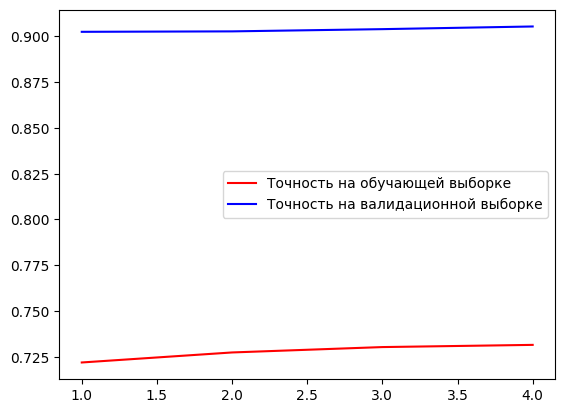

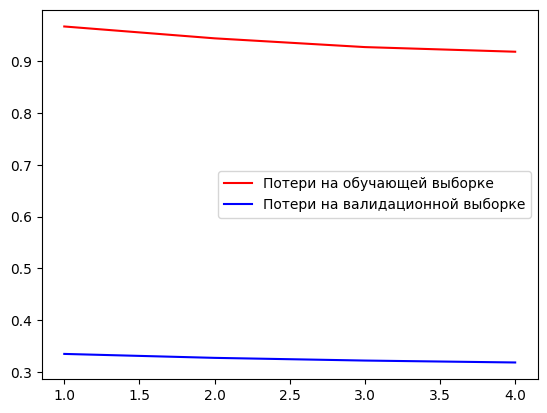

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

# Тестирование

--2024-11-23 10:21:23--  https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47310 (46K) [image/jpeg]
Saving to: ‘Cardigan.jpeg’

Cardigan.jpeg       100%[===================>]  46.20K   261KB/s    in 0.2s    

2024-11-23 10:21:24 (261 KB/s) - ‘Cardigan.jpeg’ saved [47310/47310]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


(-0.5, 223.5, 223.5, -0.5)

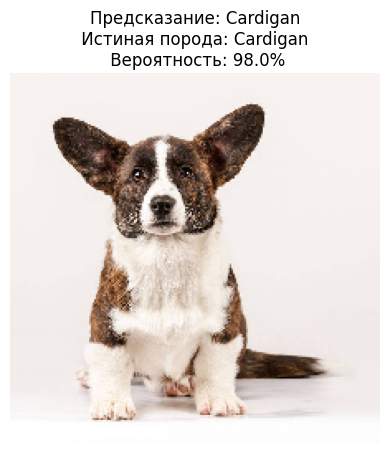

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")



In [ ]:
score = model.evaluate(test_ds,steps=50)
print(f'Точность: {score}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 284ms/step - acc: 0.9094 - loss: 0.3186
Точность: [0.3244847357273102, 0.9087837934494019]


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


# Возьмем 10 первых пород и попробуем посмотреть какую точность показывает наша модель на классификации 10 пород.

In [ ]:
import shutil
dogs = os.path.join(IMAGE_PATH,'dogs')
if not os.path.exists(dogs):
  shutil.copytree(IMAGE_PATH,dogs,copy_function=shutil.copy2)


In [ ]:
print(sorted(os.listdir(dogs))[:10])

['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle']


In [ ]:
for i in sorted(os.listdir(dogs))[10:]:
  folder_path = os.path.join(dogs,i)
  shutil.rmtree(folder_path)


In [ ]:
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
CLASS_LIST = CLASS_LIST[:10]
CLASS_COUNT = len(CLASS_LIST)
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 10
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle']


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
#Генерация датасета
train_ds,val_ds = keras.utils.image_dataset_from_directory(dogs,image_size=IMAGE_SIZE,batch_size=BATCH_SIZE,validation_split=0.2,subset='both',shuffle=True,seed=42)
print(type(train_ds))
total_size = len(train_ds)
test_size = int(0.1 * total_size)  # 10% для теста
train_size = total_size - test_size

# Создаем test_ds из оригинального train_ds
test_ds = train_ds.skip(train_size)

# Обновляем train_ds, чтобы он содержал только обучающие данные
train_ds = train_ds.take(train_size)

Found 1850 files belonging to 10 classes.
Using 1480 files for training.
Using 370 files for validation.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
#Аугментируем данные
augmentation_data_layers = [
    layers.RandomRotation(0.15),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomFlip(),
    layers.RandomTranslation(height_factor=0.1,width_factor=0.1,fill_mode='nearest')

]
# Применяем аугментацию к данным

def aug_data(images):
  for layer in augmentation_data_layers:
    images = layer(images)
  return images

In [ ]:
#Предобработаем данные применим аугментацию и one hot coding для мультклассовой классификации по типу Кошка Собака Попугай будет таблица 0 1 0. Где 1 соответсвует верному классу
train_ds = train_ds.map(lambda x,y: (aug_data(x),keras.ops.one_hot(y,CLASS_COUNT)),num_parallel_calls=tf_data.AUTOTUNE)
val_ds = val_ds.map(lambda x,y: (x,keras.ops.one_hot(y,CLASS_COUNT)),num_parallel_calls=tf_data.AUTOTUNE)
test_ds = test_ds.map(lambda x,y: (x,keras.ops.one_hot(y,CLASS_COUNT)),num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='best_model_pretrain_1.keras',monitor='val_acc',mode='max',save_best_only=True)
]

model = build_model(num_classes=CLASS_COUNT)

print(model.input_shape)
print(model.output_shape)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

(None, 224, 224, 3)
(None, 10)
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - acc: 0.6250 - loss: 1.4379 - val_acc: 0.9946 - val_loss: 0.0383
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.9051 - loss: 0.5423 - val_acc: 0.9946 - val_loss: 0.0398
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.8973 - loss: 0.4072 - val_acc: 0.9892 - val_loss: 0.0611
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9018 - loss: 0.4657 - val_acc: 0.9973 - val_loss: 0.0512
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.9209 - loss: 0.4000 - val_acc: 0.9973 - val_loss: 0.0502
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.8988 - loss: 0.4709 - val_acc: 0.9865 - val_loss: 0.0833
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.9212 - loss: 0.2970 - val_acc: 0.9892 - val_loss: 0.0453
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9071 - loss: 0.4336 - val_acc: 0.9919 - val_loss: 0.0405
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s

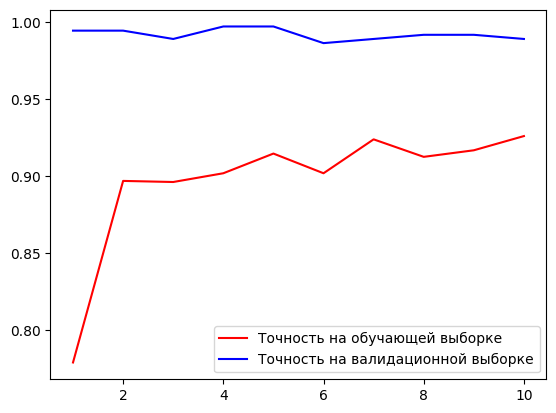

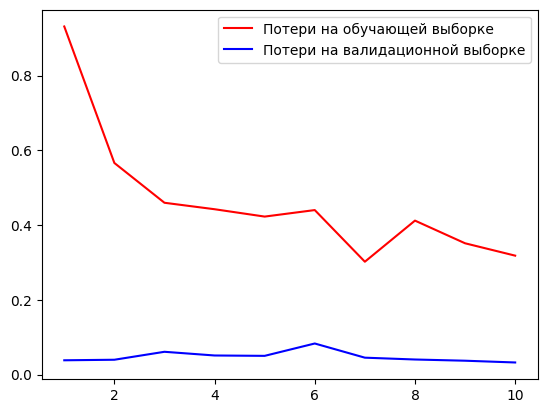

In [ ]:
show_plot(history)

In [ ]:
score = model.evaluate(test_ds,steps=50)
print(f'Точность: {score}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - acc: 1.0000 - loss: 0.0216  
Точность: [0.02159165032207966, 1.0]


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[[8.6612145e-06 3.0708588e-06 1.3259923e-06 1.8438327e-06 3.9185390e-05
  1.3799322e-04 1.6806777e-04 1.7934195e-03 9.9714559e-01 7.0090540e-04]]
['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle']


(-0.5, 223.5, 223.5, -0.5)

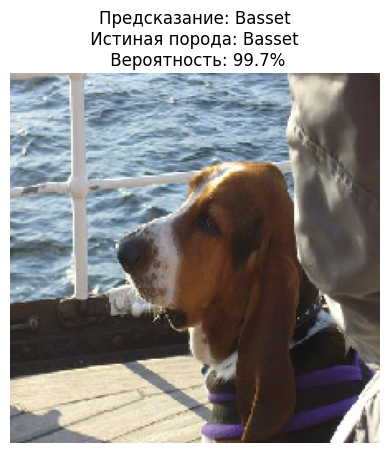

In [ ]:
TEST_IMG='/content/dataset/dogs/Basset/n02088238_10063.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)
print(predictions)
print(sorted(CLASS_LIST))

plt.title("Предсказание: %s\n Истиная порода: Basset \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")